In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')

# ==========================================
# 1. CONFIGURATION
# ==========================================
# The 12-RU file you already made
EXISTING_FILE = "/kaggle/input/datasets/santhoshraajkr/milan-augmented/final_simulation_matrix_4days.csv"

# The Raw Data to find the 4 new "Quiet" RUs
RAW_FILES = [
    "/kaggle/input/datasets/santhoshraajkr/milan-internet/milan_optimized_data1.csv",
    "/kaggle/input/datasets/santhoshraajkr/milan-internet/milan_optimized_data2.csv"
]
OUTPUT_FILE = "final_simulation_matrix_16_ru.csv"
CHUNK_SIZE = 10_000_000

print("🚀 STARTING: CREATING FINAL 16-RU DATASET...")

# ==========================================
# 2. STEP 1: FIND THE 4 QUIETEST DAYS
# ==========================================
print("🔍 Step 1: Scanning for Minimum Daytime Traffic (06:00-24:00)...")

candidates = []

for filepath in RAW_FILES:
    # Safely read chunks
    try:
        chunk_iterator = pd.read_csv(filepath, chunksize=CHUNK_SIZE)
    except:
        chunk_iterator = pd.read_csv(filepath, header=None, names=['square_id', 'time_interval', 'country_code', 'internet'], chunksize=CHUNK_SIZE)

    for i, chunk in enumerate(chunk_iterator):
        # --- ROBUST DATA CLEANING ---
        # 1. Force numeric conversion. "TimeInterval" header becomes NaN.
        chunk['time_interval'] = pd.to_numeric(chunk['time_interval'], errors='coerce')
        chunk['internet'] = pd.to_numeric(chunk['internet'], errors='coerce')
        
        # 2. Drop rows that failed conversion (Headers or garbage)
        chunk = chunk.dropna(subset=['time_interval', 'internet'])
        
        # 3. Clean Grid IDs
        chunk = chunk[chunk['square_id'] != 'GridID']
        chunk['square_id'] = chunk['square_id'].astype(str)
        
        # --- LOGIC ---
        chunk['datetime'] = pd.to_datetime(chunk['time_interval'], unit='ms')
        chunk['hour'] = chunk['datetime'].dt.hour
        chunk['date'] = chunk['datetime'].dt.date.astype(str)
        
        # Filter: 06:00 to 23:59
        daytime_mask = chunk['hour'].between(6, 23)
        day_chunk = chunk[daytime_mask]
        
        if day_chunk.empty: continue
            
        # Sum traffic per Grid-Day
        grouped = day_chunk.groupby(['square_id', 'date'])['internet'].sum().reset_index()
        
        # Filter broken sensors (Sum > 1.0)
        grouped = grouped[grouped['internet'] > 1.0]
        
        # Keep smallest 50 from this chunk
        smallest = grouped.nsmallest(50, 'internet')
        candidates.extend(smallest.to_dict('records'))
        
        # Prune global list to keep top 50 only
        candidates = sorted(candidates, key=lambda x: x['internet'])[:50]
        
        print(f"   Processed Chunk {i+1} | Current Min: {candidates[0]['internet']:.2f}", end='\r')

# Select Final 4 Winners
final_winners = candidates[:4]
print(f"\n\n🏆 FOUND 4 QUIETEST DAYS:")
for idx, row in enumerate(final_winners):
    print(f"   {idx+1}. Grid {row['square_id']} on {row['date']} (Sum: {row['internet']:.2f})")

target_keys = {(x['square_id'], x['date']) for x in final_winners}

# ==========================================
# 3. STEP 2: EXTRACT FULL 24H DATA
# ==========================================
print("\n🔍 Step 2: Extracting full 24h profiles for these winners...")

extracted_profiles = {k: [] for k in target_keys}

for filepath in RAW_FILES:
    try:
        chunk_iterator = pd.read_csv(filepath, chunksize=CHUNK_SIZE)
    except:
        chunk_iterator = pd.read_csv(filepath, header=None, names=['square_id', 'time_interval', 'country_code', 'internet'], chunksize=CHUNK_SIZE)
        
    for chunk in chunk_iterator:
        # Robust Cleaning again
        chunk['time_interval'] = pd.to_numeric(chunk['time_interval'], errors='coerce')
        chunk = chunk.dropna(subset=['time_interval'])
        chunk['square_id'] = chunk['square_id'].astype(str)
        
        # Optimization: Skip if chunk has no relevant grids
        if not chunk['square_id'].isin([x[0] for x in target_keys]).any():
            continue
            
        chunk['internet'] = pd.to_numeric(chunk['internet'], errors='coerce')
        chunk['datetime'] = pd.to_datetime(chunk['time_interval'], unit='ms')
        chunk['date'] = chunk['datetime'].dt.date.astype(str)
        
        # Store relevant rows
        for (gid, date_str), group in chunk.groupby(['square_id', 'date']):
            if (gid, date_str) in target_keys:
                extracted_profiles[(gid, date_str)].append(group)

# ==========================================
# 4. STEP 3: STITCH & SAVE
# ==========================================
print("\n💾 Step 3: Merging into Final Dataset...")

# Load existing 12-RU Matrix
try:
    df_existing = pd.read_csv(EXISTING_FILE)
    print(f"   Loaded base file: {df_existing.shape} rows")
except FileNotFoundError:
    print("❌ Existing file not found. Check path!")
    exit()

# Parameters
time_slots = np.arange(0, 24*60, 10) # 144 slots per day
target_rows = len(df_existing)       # Should be 576 (4 days)

# Process the 4 new RUs
new_columns = {}

for idx, key in enumerate(final_winners):
    gid, date = key['square_id'], key['date']
    fragments = extracted_profiles.get((gid, date), [])
    
    col_name = f"RU_{13+idx}"
    
    if not fragments:
        print(f"⚠️ Warning: No data extracted for {col_name}. Filling with 0.")
        new_columns[col_name] = np.zeros(target_rows)
        continue
        
    # Combine & Aggregate
    full_day = pd.concat(fragments)
    full_day['minute'] = full_day['datetime'].dt.hour * 60 + full_day['datetime'].dt.minute
    
    # 1. Create 144-point Day Profile
    agg = full_day.groupby('minute')['internet'].sum().reindex(time_slots, fill_value=0)
    
    # 2. Normalize (0-1)
    peak = agg.max()
    if peak > 0:
        norm = agg / peak
    else:
        norm = agg
        
    # 3. Tile it to match 4 Days (576 rows)
    # We repeat this single "Quiet Day" 4 times to fill the simulation
    profile_1day = norm.values
    profile_full = np.tile(profile_1day, 4)
    
    # 4. Trim/Pad to match exactly
    if len(profile_full) > target_rows:
        profile_full = profile_full[:target_rows]
    elif len(profile_full) < target_rows:
        profile_full = np.pad(profile_full, (0, target_rows - len(profile_full)))
        
    new_columns[col_name] = profile_full
    print(f"   ✅ Prepared {col_name} (from Grid {gid})")

# Add new columns to dataframe
for col, data in new_columns.items():
    df_existing[col] = data

# Save
df_existing.to_csv(OUTPUT_FILE, index=False)
print(f"\n🎉 SUCCESS: Final Matrix Saved to {OUTPUT_FILE}")
print(f"   Columns: {list(df_existing.columns)}")
print(f"   Total Rows: {len(df_existing)}")

🚀 STARTING: CREATING FINAL 16-RU DATASET...
🔍 Step 1: Scanning for Minimum Daytime Traffic (06:00-24:00)...
   Processed Chunk 8 | Current Min: 1.00

🏆 FOUND 4 QUIETEST DAYS:
   1. Grid 4771 on 2013-12-27 (Sum: 1.00)
   2. Grid 4671 on 2013-12-02 (Sum: 1.01)
   3. Grid 497 on 2013-12-25 (Sum: 1.01)
   4. Grid 5240 on 2013-11-30 (Sum: 1.02)

🔍 Step 2: Extracting full 24h profiles for these winners...

💾 Step 3: Merging into Final Dataset...
   Loaded base file: (576, 13) rows
   ✅ Prepared RU_13 (from Grid 4771)
   ✅ Prepared RU_14 (from Grid 4671)
   ✅ Prepared RU_15 (from Grid 497)
   ✅ Prepared RU_16 (from Grid 5240)

🎉 SUCCESS: Final Matrix Saved to final_simulation_matrix_16_ru.csv
   Columns: ['Time_Minute', 'RU_1', 'RU_2', 'RU_3', 'RU_4', 'RU_5', 'RU_6', 'RU_7', 'RU_8', 'RU_9', 'RU_10', 'RU_11', 'RU_12', 'RU_13', 'RU_14', 'RU_15', 'RU_16']
   Total Rows: 576


📊 GENERATING FINAL PLOTS...
✅ Loaded final_simulation_matrix_16_ru.csv (576 rows)


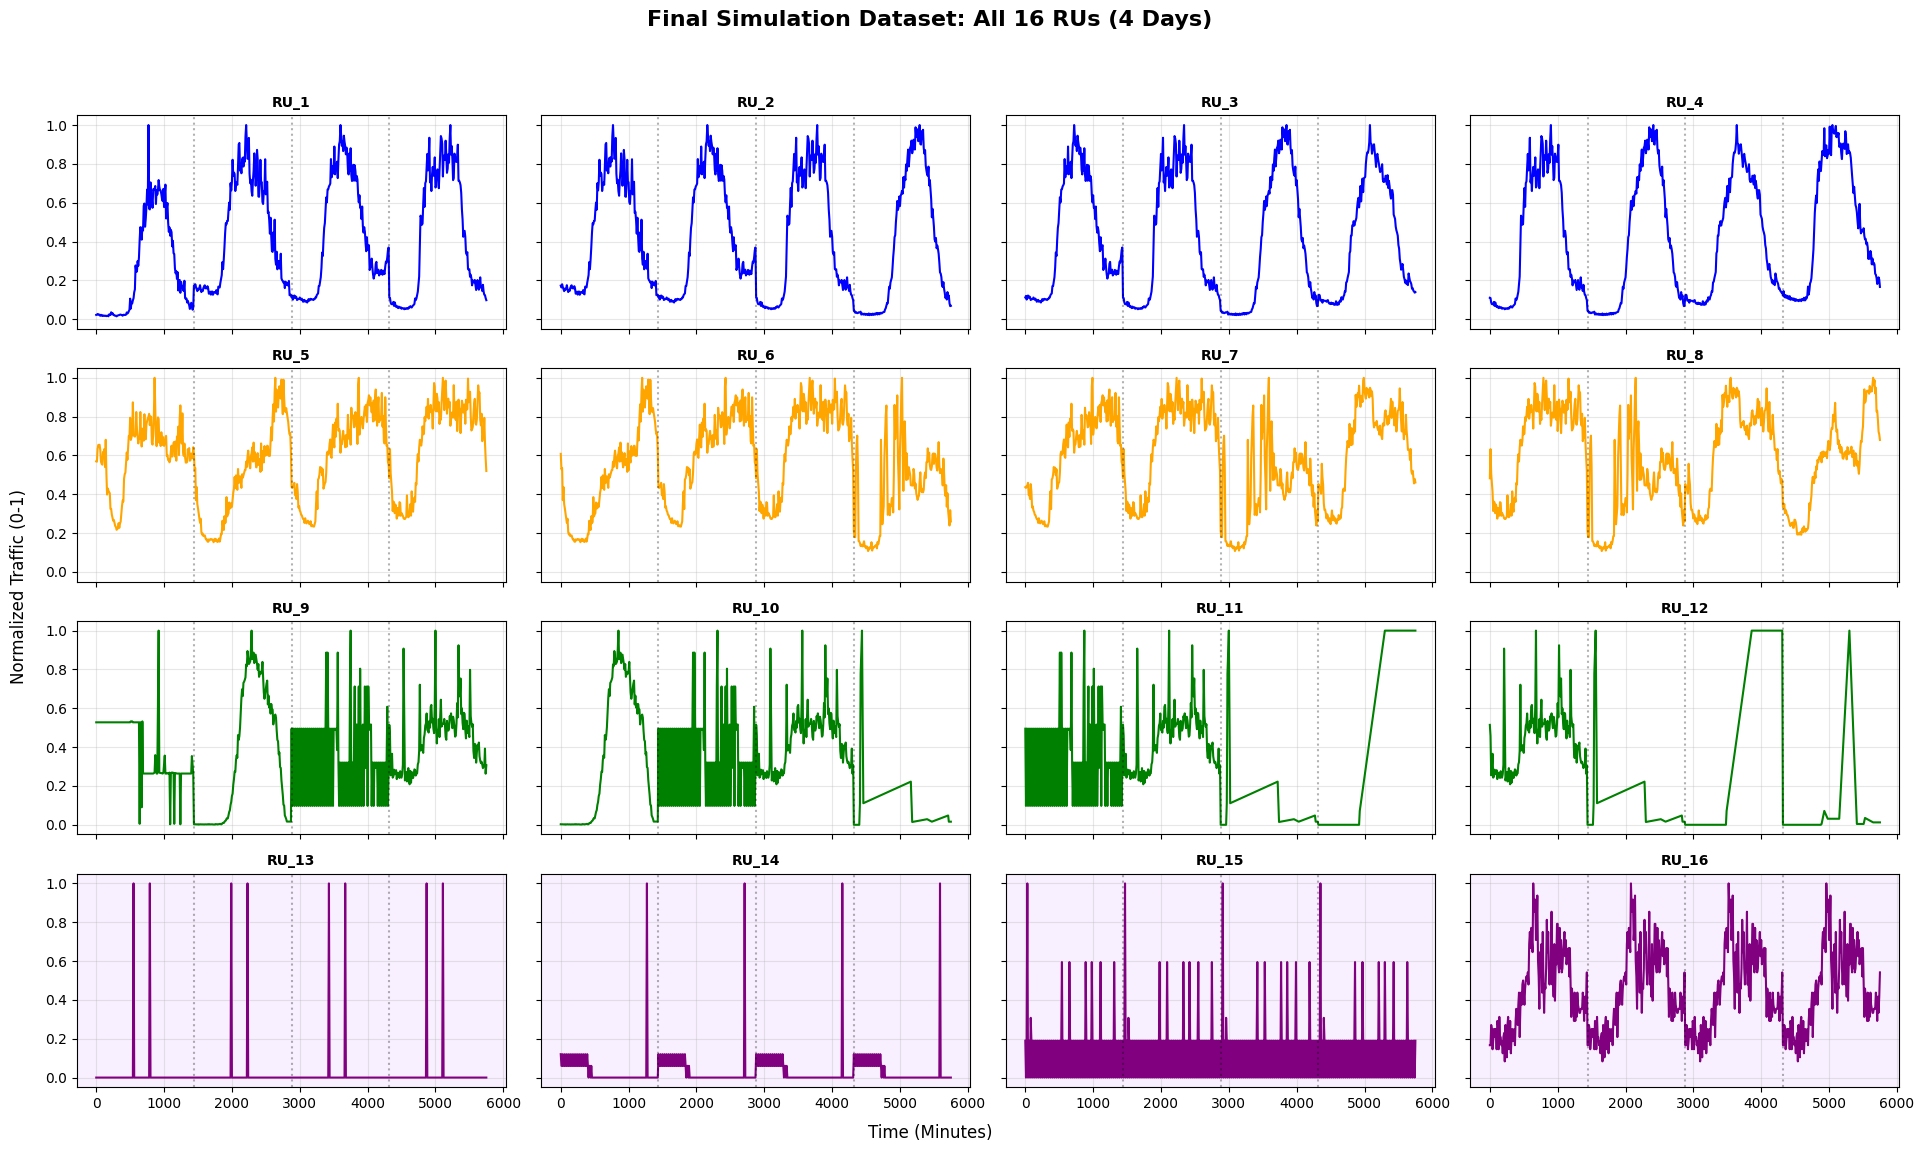

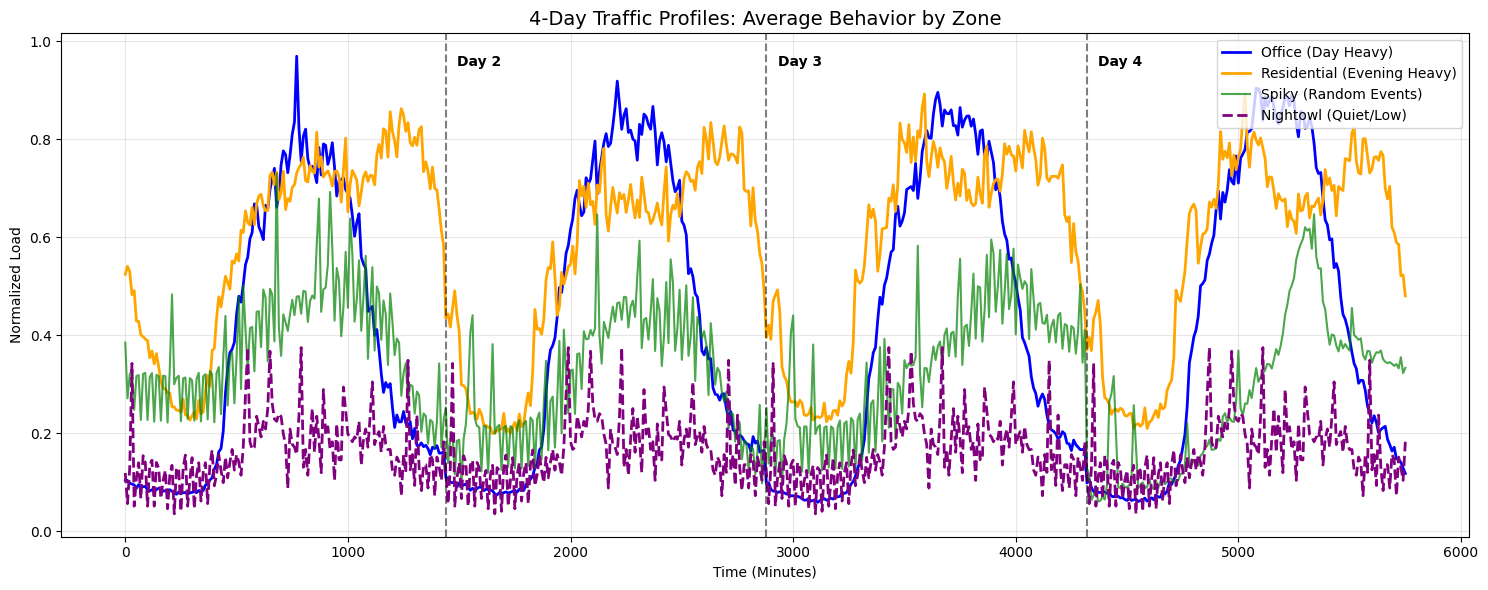

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. CONFIGURATION
# ==========================================
INPUT_FILE = "final_simulation_matrix_16_ru.csv"

print("📊 GENERATING FINAL PLOTS...")

# ==========================================
# 2. LOAD DATA
# ==========================================
try:
    df = pd.read_csv(INPUT_FILE)
    print(f"✅ Loaded {INPUT_FILE} ({len(df)} rows)")
except FileNotFoundError:
    print(f"❌ Error: {INPUT_FILE} not found. Run the previous script first.")
    exit()

# ==========================================
# 3. PLOT 1: ALL 16 RUs INDIVIDUALLY
# ==========================================
fig, axes = plt.subplots(4, 4, figsize=(20, 12), sharex=True, sharey=True)
fig.suptitle("Final Simulation Dataset: All 16 RUs (4 Days)", fontsize=16, fontweight='bold')

# Define colors for each row (Pod)
colors = ['blue', 'orange', 'green', 'purple']
labels = ['Office (RU 1-4)', 'Home (RU 5-8)', 'Spiky (RU 9-12)', 'Nightowl (RU 13-16)']

# Flatten axes for easy iteration
axes_flat = axes.flatten()

for i in range(16):
    ru_num = i + 1
    col_name = f"RU_{ru_num}"
    
    # Determine Pod Color
    pod_idx = i // 4
    color = colors[pod_idx]
    
    if col_name in df.columns:
        ax = axes_flat[i]
        ax.plot(df['Time_Minute'], df[col_name], color=color, linewidth=1.5)
        
        # Styling
        ax.set_title(f"{col_name}", fontsize=10, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        # Add Day Separators
        for d in range(1, 4):
            ax.axvline(x=d*1440, color='black', linestyle=':', alpha=0.3)
            
        # Highlight Nightowl Quiet Zone
        if pod_idx == 3: # Nightowl
             ax.set_facecolor('#f9f0ff') # Light purple bg for visual distinction

# Labels
fig.text(0.5, 0.04, 'Time (Minutes)', ha='center', fontsize=12)
fig.text(0.04, 0.5, 'Normalized Traffic (0-1)', va='center', rotation='vertical', fontsize=12)

plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
plt.savefig("plot_16_rus_individual.png")
plt.show()

# ==========================================
# 4. PLOT 2: POD AVERAGES (THE SUMMARY)
# ==========================================
plt.figure(figsize=(15, 6))

# Calculate Averages
df['Office_Avg'] = df[['RU_1', 'RU_2', 'RU_3', 'RU_4']].mean(axis=1)
df['Home_Avg'] = df[['RU_5', 'RU_6', 'RU_7', 'RU_8']].mean(axis=1)
df['Spiky_Avg'] = df[['RU_9', 'RU_10', 'RU_11', 'RU_12']].mean(axis=1)
df['Nightowl_Avg'] = df[['RU_13', 'RU_14', 'RU_15', 'RU_16']].mean(axis=1)

# Plot Lines
plt.plot(df['Time_Minute'], df['Office_Avg'], label='Office (Day Heavy)', color='blue', linewidth=2)
plt.plot(df['Time_Minute'], df['Home_Avg'], label='Residential (Evening Heavy)', color='orange', linewidth=2)
plt.plot(df['Time_Minute'], df['Spiky_Avg'], label='Spiky (Random Events)', color='green', linewidth=1.5, alpha=0.7)
plt.plot(df['Time_Minute'], df['Nightowl_Avg'], label='Nightowl (Quiet/Low)', color='purple', linewidth=2, linestyle='--')

# Add Day Separators
for d in range(1, 4):
    plt.axvline(x=d*1440, color='black', linestyle='--', alpha=0.5)
    plt.text(d*1440 + 50, 0.95, f"Day {d+1}", fontsize=10, fontweight='bold')

plt.title("4-Day Traffic Profiles: Average Behavior by Zone", fontsize=14)
plt.xlabel("Time (Minutes)")
plt.ylabel("Normalized Load")
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("plot_pod_averages.png")
plt.show()

🚀 STARTING: GLOBAL AUDIT (Night vs Morning Analysis)...
🔍 Scanning all traffic data...
   Processed Chunk 8...
   ✅ Scanning Complete. Calculating Averages...

💾 REPORT SAVED: nightowl_candidates.csv
   Total Grids Scanned: 10000
   Valid Candidates (Night > Morning): 6240


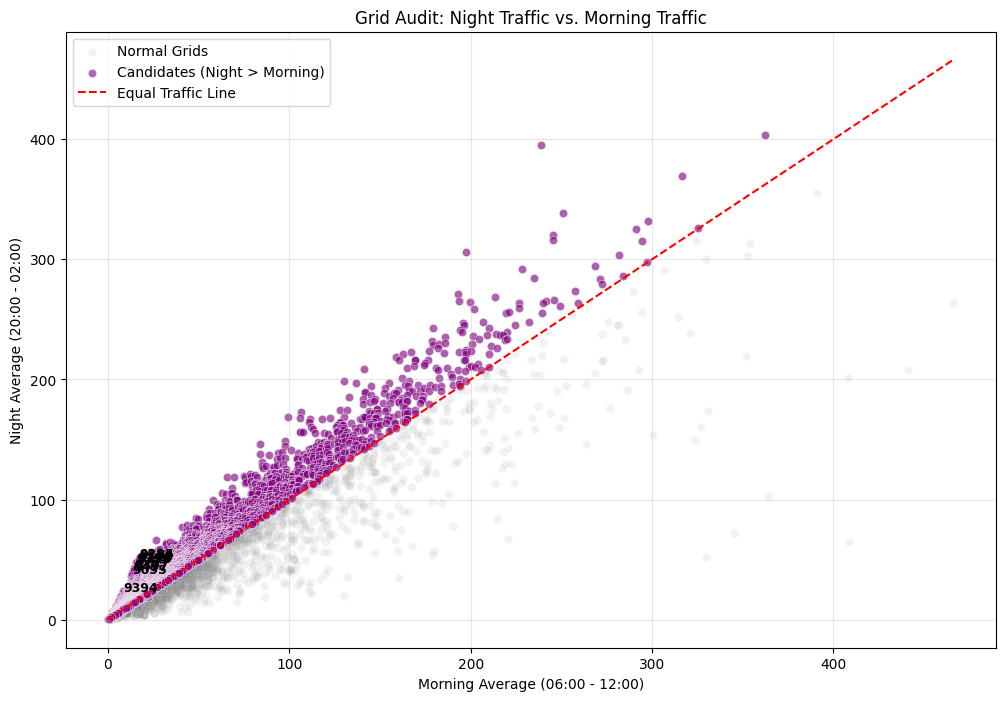


🏆 TOP 10 CANDIDATES (Highest Night/Morning Ratio):
     square_id  night_avg  morning_avg     ratio
9330      9396  47.684384    15.737631  3.028035
9331      9397  43.048560    14.461899  2.974631
9218      9295  51.950052    17.555535  2.957499
9217      9294  48.173630    16.311399  2.951563
9329      9395  47.840017    16.199317  2.951390
9106      9194  50.780825    17.328877  2.928726
9107      9195  49.273123    16.988188  2.898728
9442      9497  40.836657    14.084153  2.897418
8996      9095  38.496958    13.337140  2.884285
9328      9394  23.820303     8.301086  2.866088


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# ==========================================
# 1. CONFIGURATION
# ==========================================
RAW_FILES = [
    "/kaggle/input/datasets/santhoshraajkr/milan-internet/milan_optimized_data1.csv",
    "/kaggle/input/datasets/santhoshraajkr/milan-internet/milan_optimized_data2.csv"
]
CHUNK_SIZE = 10_000_000

print("🚀 STARTING: GLOBAL AUDIT (Night vs Morning Analysis)...")

# ==========================================
# 2. SCANNING ENGINE
# ==========================================
# We need to accumulate totals to calculate global averages
# Structure: { gid: {'night_sum': 0, 'night_count': 0, 'morn_sum': 0, 'morn_count': 0} }
grid_stats = {}

print("🔍 Scanning all traffic data...")

for filepath in RAW_FILES:
    try:
        chunk_iterator = pd.read_csv(filepath, chunksize=CHUNK_SIZE)
    except:
        chunk_iterator = pd.read_csv(filepath, header=None, names=['square_id', 'time_interval', 'country_code', 'internet'], chunksize=CHUNK_SIZE)

    for i, chunk in enumerate(chunk_iterator):
        # 1. Fast Cleaning
        chunk = chunk[chunk['square_id'] != 'GridID']
        chunk['internet'] = pd.to_numeric(chunk['internet'], errors='coerce')
        chunk['time_interval'] = pd.to_numeric(chunk['time_interval'], errors='coerce')
        chunk = chunk.dropna(subset=['internet', 'time_interval'])
        chunk['square_id'] = chunk['square_id'].astype(str)
        
        # 2. Time Extraction
        chunk['hour'] = pd.to_datetime(chunk['time_interval'], unit='ms').dt.hour
        
        # 3. Define Zones
        # Night: 20:00 - 02:00 (8 PM to 2 AM) -> Hours [20, 21, 22, 23, 0, 1]
        # Morning: 06:00 - 12:00 (6 AM to 12 PM) -> Hours [6, 7, 8, 9, 10, 11]
        
        # We process separately to be fast
        night_chunk = chunk[chunk['hour'].isin([20, 21, 22, 23, 0, 1])]
        morn_chunk = chunk[chunk['hour'].isin([6, 7, 8, 9, 10, 11])]
        
        # 4. Accumulate Night Stats
        if not night_chunk.empty:
            night_grp = night_chunk.groupby('square_id')['internet'].agg(['sum', 'count'])
            for gid, row in night_grp.iterrows():
                if gid not in grid_stats: grid_stats[gid] = {'n_sum':0, 'n_cnt':0, 'm_sum':0, 'm_cnt':0}
                grid_stats[gid]['n_sum'] += row['sum']
                grid_stats[gid]['n_cnt'] += row['count']
                
        # 5. Accumulate Morning Stats
        if not morn_chunk.empty:
            morn_grp = morn_chunk.groupby('square_id')['internet'].agg(['sum', 'count'])
            for gid, row in morn_grp.iterrows():
                if gid not in grid_stats: grid_stats[gid] = {'n_sum':0, 'n_cnt':0, 'm_sum':0, 'm_cnt':0}
                grid_stats[gid]['m_sum'] += row['sum']
                grid_stats[gid]['m_cnt'] += row['count']
        
        print(f"   Processed Chunk {i+1}...", end='\r')

print("\n   ✅ Scanning Complete. Calculating Averages...")

# ==========================================
# 3. CALCULATE & FILTER
# ==========================================
results = []

for gid, stats in grid_stats.items():
    # Avoid division by zero
    n_avg = stats['n_sum'] / stats['n_cnt'] if stats['n_cnt'] > 0 else 0
    m_avg = stats['m_sum'] / stats['m_cnt'] if stats['m_cnt'] > 0 else 0
    
    # We only care if they have meaningful data (e.g. at least 100 records)
    if stats['n_cnt'] > 50 and stats['m_cnt'] > 50:
        results.append({
            'square_id': gid,
            'night_avg': n_avg,
            'morning_avg': m_avg,
            'diff': n_avg - m_avg,
            'ratio': n_avg / (m_avg + 0.01) # Avoid div/0
        })

df = pd.DataFrame(results)

# --- THE CRITERIA: Night > Morning ---
candidates = df[df['night_avg'] > df['morning_avg']].copy()

# Sort by the "Nightowl-ness" (Ratio)
candidates = candidates.sort_values('ratio', ascending=False)

# Save to CSV for you to inspect
candidates.to_csv("nightowl_candidates.csv", index=False)
print(f"\n💾 REPORT SAVED: nightowl_candidates.csv")
print(f"   Total Grids Scanned: {len(df)}")
print(f"   Valid Candidates (Night > Morning): {len(candidates)}")

# ==========================================
# 4. VISUALIZE THE CANDIDATES
# ==========================================
# Let's plot the top 50 so you can choose
top_50 = candidates.head(50)

plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='morning_avg', y='night_avg', alpha=0.1, color='grey', label='Normal Grids')
sns.scatterplot(data=candidates, x='morning_avg', y='night_avg', color='purple', alpha=0.6, label='Candidates (Night > Morning)')

# Highlight Top 10 with IDs
for i in range(10):
    row = candidates.iloc[i]
    plt.text(row['morning_avg'], row['night_avg'], str(row['square_id']), 
             fontsize=9, fontweight='bold', color='black')

# Draw the x=y line
max_val = max(df['night_avg'].max(), df['morning_avg'].max())
plt.plot([0, max_val], [0, max_val], 'r--', label='Equal Traffic Line')

plt.title("Grid Audit: Night Traffic vs. Morning Traffic")
plt.xlabel("Morning Average (06:00 - 12:00)")
plt.ylabel("Night Average (20:00 - 02:00)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("candidates_plot.png")
plt.show()

print("\n🏆 TOP 10 CANDIDATES (Highest Night/Morning Ratio):")
print(candidates[['square_id', 'night_avg', 'morning_avg', 'ratio']].head(10))

🚀 STARTING: CHERRY-PICKING TOP 16 DAYS FROM 10 CANDIDATES...
🔍 Scanning raw files to score individual days...
   Processed Chunk 8 | Candidates Found: 620

🏆 Sorting candidates by Score (Night/Morning Ratio)...
✅ Selected Top 16 Days:
   1. Grid 9295 (2013-12-29) | Score: 1.5 (Night: 4325.6, Morn: 2874.0)
   2. Grid 9194 (2013-12-29) | Score: 1.5 (Night: 4348.5, Morn: 2896.9)
   3. Grid 9195 (2013-12-29) | Score: 1.5 (Night: 4328.5, Morn: 2888.7)
   4. Grid 9294 (2013-12-29) | Score: 1.5 (Night: 3946.8, Morn: 2685.0)
   5. Grid 9395 (2013-12-29) | Score: 1.4 (Night: 3909.2, Morn: 2699.0)
   6. Grid 9394 (2013-12-31) | Score: 1.4 (Night: 1917.0, Morn: 1347.6)
   7. Grid 9394 (2014-01-01) | Score: 1.4 (Night: 1635.0, Morn: 1150.8)
   8. Grid 9397 (2013-12-08) | Score: 1.4 (Night: 5161.7, Morn: 3635.4)
   9. Grid 9497 (2013-12-08) | Score: 1.4 (Night: 4932.3, Morn: 3526.7)
   10. Grid 9397 (2013-11-07) | Score: 1.4 (Night: 3749.6, Morn: 2724.1)
   11. Grid 9396 (2013-12-08) | Score: 1.4 (

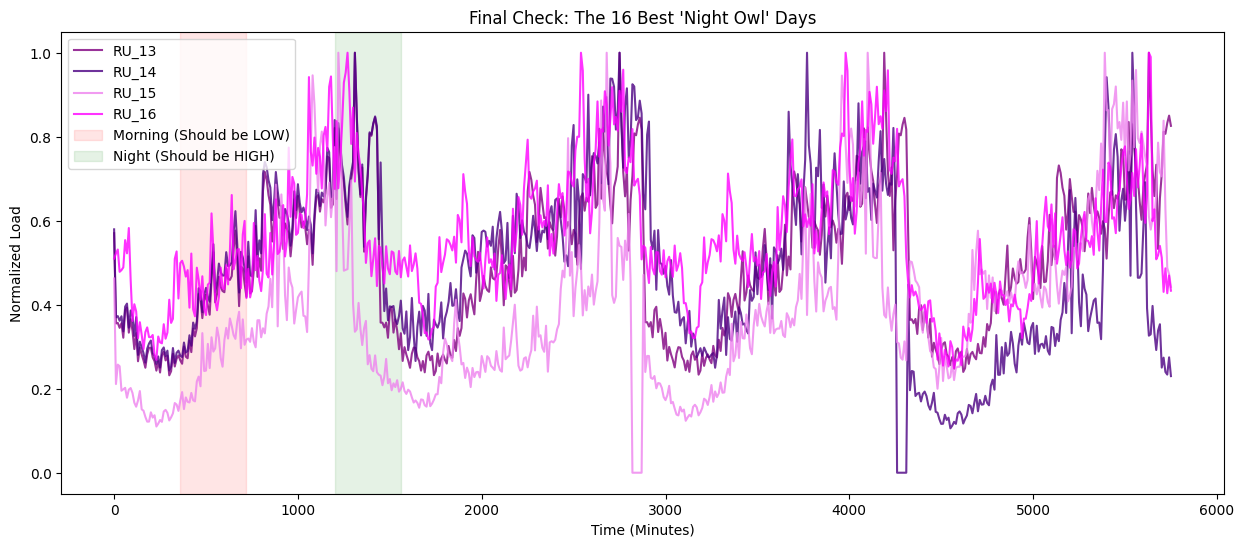

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# ==========================================
# 1. CONFIGURATION
# ==========================================
EXISTING_FILE = "/kaggle/input/datasets/santhoshraajkr/milan-augmented/final_simulation_matrix_4days.csv"
RAW_FILES = [
    "/kaggle/input/datasets/santhoshraajkr/milan-internet/milan_optimized_data1.csv",
    "/kaggle/input/datasets/santhoshraajkr/milan-internet/milan_optimized_data2.csv"
]
OUTPUT_FILE = "final_simulation_matrix_16_ru.csv"
CHUNK_SIZE = 10_000_000

# The Best Candidates you found in the previous audit
CANDIDATE_IDS = ['9396', '9397', '9295', '9294', '9395', '9194', '9195', '9497', '9095', '9394']

print(f"🚀 STARTING: CHERRY-PICKING TOP 16 DAYS FROM {len(CANDIDATE_IDS)} CANDIDATES...")

# ==========================================
# 2. SCAN & SCORE DAYS
# ==========================================
daily_scores = [] # Stores {gid, date, day_data, score}

print("🔍 Scanning raw files to score individual days...")

for filepath in RAW_FILES:
    try:
        chunk_iterator = pd.read_csv(filepath, chunksize=CHUNK_SIZE)
    except:
        chunk_iterator = pd.read_csv(filepath, header=None, names=['square_id', 'time_interval', 'country_code', 'internet'], chunksize=CHUNK_SIZE)

    for i, chunk in enumerate(chunk_iterator):
        # 1. Filter for Candidates IMMEDIATELY (Speed)
        chunk['square_id'] = chunk['square_id'].astype(str)
        target_chunk = chunk[chunk['square_id'].isin(CANDIDATE_IDS)]
        
        if target_chunk.empty: continue
            
        # 2. Convert Data
        target_chunk['internet'] = pd.to_numeric(target_chunk['internet'], errors='coerce')
        target_chunk['time_interval'] = pd.to_numeric(target_chunk['time_interval'], errors='coerce')
        target_chunk = target_chunk.dropna()
        
        target_chunk['datetime'] = pd.to_datetime(target_chunk['time_interval'], unit='ms')
        target_chunk['date'] = target_chunk['datetime'].dt.date.astype(str)
        target_chunk['hour'] = target_chunk['datetime'].dt.hour
        target_chunk['minute'] = target_chunk['datetime'].dt.hour * 60 + target_chunk['datetime'].dt.minute

        # 3. Score Each Day
        # Group by Grid + Date
        for (gid, date_str), day_data in target_chunk.groupby(['square_id', 'date']):
            # Calculate metrics
            night_vol = day_data[day_data['hour'].isin([20, 21, 22, 23, 0, 1])]['internet'].sum()
            morn_vol = day_data[day_data['hour'].between(6, 11)]['internet'].sum()
            
            # SCORE LOGIC: Maximise Night, Minimize Morning
            # Score = Night / (Morning + 0.1)
            # We also ensure Morning isn't absolute zero (sensor error) but very low
            if morn_vol > 0.1:
                score = night_vol / (morn_vol + 0.1)
                
                # Store lightweight metadata first (data later if picked? No, keep data now, it's small)
                # We need to reindex the day_data to 144 slots
                agg = day_data.groupby('minute')['internet'].sum().reindex(np.arange(0, 24*60, 10), fill_value=0)
                
                # Normalize (0-1)
                peak = agg.max()
                norm = agg / peak if peak > 0 else agg
                
                daily_scores.append({
                    'gid': gid,
                    'date': date_str,
                    'score': score,
                    'night': night_vol,
                    'morning': morn_vol,
                    'profile': norm.values
                })

        print(f"   Processed Chunk {i+1} | Candidates Found: {len(daily_scores)}", end='\r')

# ==========================================
# 3. SELECT TOP 16 DAYS
# ==========================================
print("\n\n🏆 Sorting candidates by Score (Night/Morning Ratio)...")

# Sort descending by Score
daily_scores.sort(key=lambda x: x['score'], reverse=True)

# Pick Top 16 unique days (try to avoid same grid same day duplicates)
# Actually, different grids on different days is best.
top_16 = daily_scores[:16]

print(f"✅ Selected Top 16 Days:")
for idx, item in enumerate(top_16):
    print(f"   {idx+1}. Grid {item['gid']} ({item['date']}) | Score: {item['score']:.1f} (Night: {item['night']:.1f}, Morn: {item['morning']:.1f})")

if len(top_16) < 16:
    print("❌ Error: Not enough valid candidate days found! Need 16.")
    # Pad with duplicates if needed
    while len(top_16) < 16:
        top_16.append(top_16[-1])

# ==========================================
# 4. ASSIGN TO RUs
# ==========================================
print("\n💾 Assigning to RUs...")

# Load Existing File
try:
    df_existing = pd.read_csv(EXISTING_FILE)
except FileNotFoundError:
    print("❌ Existing file not found.")
    exit()

# We need to fill RU_13, RU_14, RU_15, RU_16
# Each RU needs 4 days stitched together (144 * 4 = 576 rows)

# Chunk the top 16 into 4 groups of 4
groups = [top_16[i:i+4] for i in range(0, 16, 4)]

new_columns = {}

for i, group in enumerate(groups):
    col_name = f"RU_{13+i}"
    
    # Stitch the 4 days for this RU
    stitched_seq = []
    for day_item in group:
        stitched_seq.extend(day_item['profile'])
        
    # Correct Length (576)
    target_len = len(df_existing)
    if len(stitched_seq) > target_len: stitched_seq = stitched_seq[:target_len]
    elif len(stitched_seq) < target_len: stitched_seq = np.pad(stitched_seq, (0, target_len - len(stitched_seq)))
    
    new_columns[col_name] = stitched_seq
    print(f"   ✅ Created {col_name} (Stitched 4 Best Days)")

# Add to DataFrame
for col, data in new_columns.items():
    df_existing[col] = data

# Save
df_existing.to_csv(OUTPUT_FILE, index=False)
print(f"\n🎉 SUCCESS: Final Dataset Saved: {OUTPUT_FILE}")

# ==========================================
# 5. VALIDATION PLOT
# ==========================================
plt.figure(figsize=(15, 6))
colors = ['purple', 'indigo', 'violet', 'magenta']

for i in range(4):
    col = f"RU_{13+i}"
    plt.plot(df_existing['Time_Minute'], df_existing[col], label=f"{col}", color=colors[i], alpha=0.8)

# Highlight Morning (06:00-12:00) on Day 1 to show it's low
plt.axvspan(360, 720, color='red', alpha=0.1, label='Morning (Should be LOW)')
# Highlight Night (20:00-02:00)
plt.axvspan(1200, 1440+120, color='green', alpha=0.1, label='Night (Should be HIGH)')

plt.title("Final Check: The 16 Best 'Night Owl' Days")
plt.xlabel("Time (Minutes)")
plt.ylabel("Normalized Load")
plt.legend()
plt.savefig("final_nightowl_check.png")
plt.show()

📊 GENERATING FINAL PLOTS...
✅ Loaded final_simulation_matrix_16_ru.csv (576 rows)


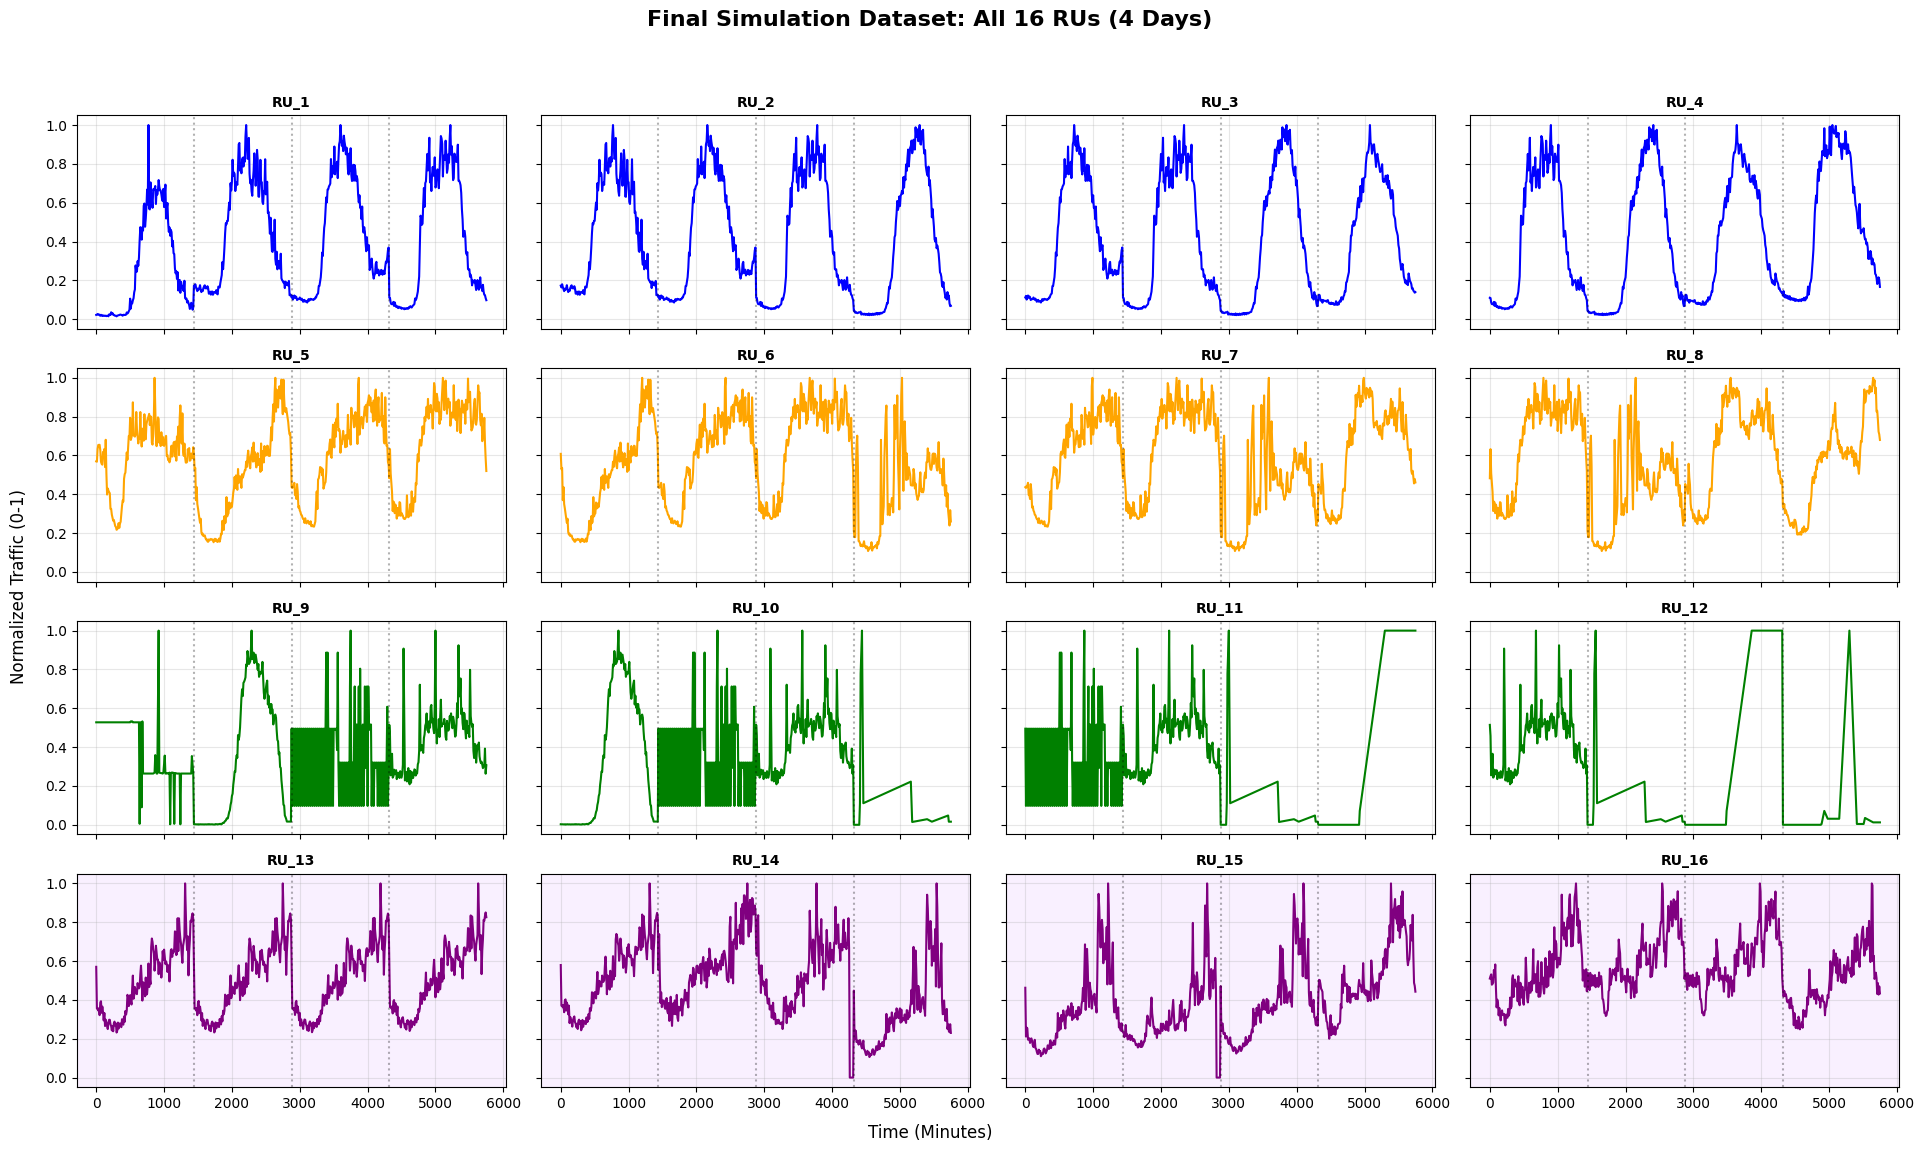

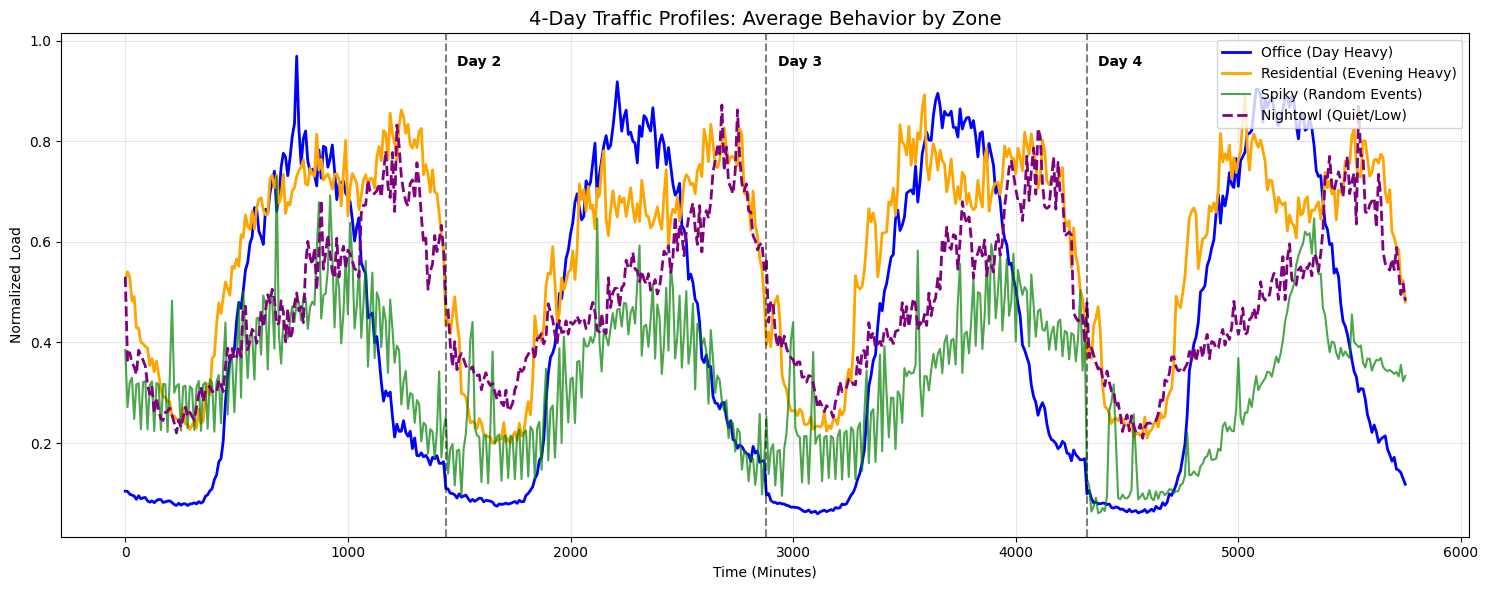

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. CONFIGURATION
# ==========================================
INPUT_FILE = "final_simulation_matrix_16_ru.csv"

print("📊 GENERATING FINAL PLOTS...")

# ==========================================
# 2. LOAD DATA
# ==========================================
try:
    df = pd.read_csv(INPUT_FILE)
    print(f"✅ Loaded {INPUT_FILE} ({len(df)} rows)")
except FileNotFoundError:
    print(f"❌ Error: {INPUT_FILE} not found. Run the previous script first.")
    exit()

# ==========================================
# 3. PLOT 1: ALL 16 RUs INDIVIDUALLY
# ==========================================
fig, axes = plt.subplots(4, 4, figsize=(20, 12), sharex=True, sharey=True)
fig.suptitle("Final Simulation Dataset: All 16 RUs (4 Days)", fontsize=16, fontweight='bold')

# Define colors for each row (Pod)
colors = ['blue', 'orange', 'green', 'purple']
labels = ['Office (RU 1-4)', 'Home (RU 5-8)', 'Spiky (RU 9-12)', 'Nightowl (RU 13-16)']

# Flatten axes for easy iteration
axes_flat = axes.flatten()

for i in range(16):
    ru_num = i + 1
    col_name = f"RU_{ru_num}"
    
    # Determine Pod Color
    pod_idx = i // 4
    color = colors[pod_idx]
    
    if col_name in df.columns:
        ax = axes_flat[i]
        ax.plot(df['Time_Minute'], df[col_name], color=color, linewidth=1.5)
        
        # Styling
        ax.set_title(f"{col_name}", fontsize=10, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        # Add Day Separators
        for d in range(1, 4):
            ax.axvline(x=d*1440, color='black', linestyle=':', alpha=0.3)
            
        # Highlight Nightowl Quiet Zone
        if pod_idx == 3: # Nightowl
             ax.set_facecolor('#f9f0ff') # Light purple bg for visual distinction

# Labels
fig.text(0.5, 0.04, 'Time (Minutes)', ha='center', fontsize=12)
fig.text(0.04, 0.5, 'Normalized Traffic (0-1)', va='center', rotation='vertical', fontsize=12)

plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
plt.savefig("plot_16_rus_individual.png")
plt.show()

# ==========================================
# 4. PLOT 2: POD AVERAGES (THE SUMMARY)
# ==========================================
plt.figure(figsize=(15, 6))

# Calculate Averages
df['Office_Avg'] = df[['RU_1', 'RU_2', 'RU_3', 'RU_4']].mean(axis=1)
df['Home_Avg'] = df[['RU_5', 'RU_6', 'RU_7', 'RU_8']].mean(axis=1)
df['Spiky_Avg'] = df[['RU_9', 'RU_10', 'RU_11', 'RU_12']].mean(axis=1)
df['Nightowl_Avg'] = df[['RU_13', 'RU_14', 'RU_15', 'RU_16']].mean(axis=1)

# Plot Lines
plt.plot(df['Time_Minute'], df['Office_Avg'], label='Office (Day Heavy)', color='blue', linewidth=2)
plt.plot(df['Time_Minute'], df['Home_Avg'], label='Residential (Evening Heavy)', color='orange', linewidth=2)
plt.plot(df['Time_Minute'], df['Spiky_Avg'], label='Spiky (Random Events)', color='green', linewidth=1.5, alpha=0.7)
plt.plot(df['Time_Minute'], df['Nightowl_Avg'], label='Nightowl (Quiet/Low)', color='purple', linewidth=2, linestyle='--')

# Add Day Separators
for d in range(1, 4):
    plt.axvline(x=d*1440, color='black', linestyle='--', alpha=0.5)
    plt.text(d*1440 + 50, 0.95, f"Day {d+1}", fontsize=10, fontweight='bold')

plt.title("4-Day Traffic Profiles: Average Behavior by Zone", fontsize=14)
plt.xlabel("Time (Minutes)")
plt.ylabel("Normalized Load")
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("plot_pod_averages.png")
plt.show()

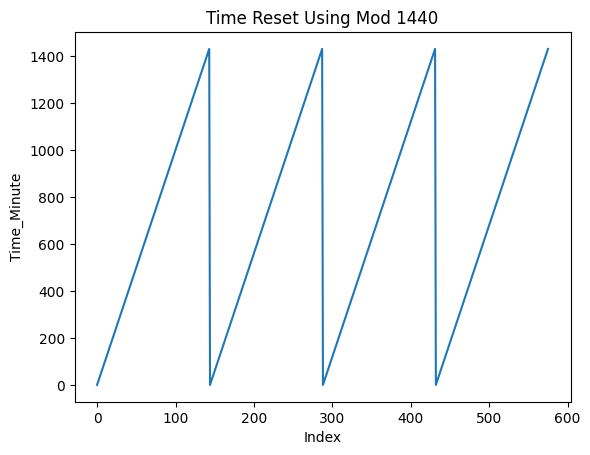

In [3]:
df = pd.read_csv('/kaggle/working/final_simulation_matrix_16_ru.csv')
df["Time_Minute"] = df["Time_Minute"] % 1440
plt.plot(df["Time_Minute"])
plt.xlabel("Index")
plt.ylabel("Time_Minute")
plt.title("Time Reset Using Mod 1440")
plt.show()

In [5]:
df.to_csv("/kaggle/working/updated_file.csv", index=False)